# PyTorchで作成したモデル，損失などを<br>TensorBoardで可視化するためのテスト

## Log を保存するためのディレクトリの作成

In [53]:
import os
import sys
sys.path.append(".")
sys.path.append("..")
from src.config.config import cfg
from utils import makedir

In [54]:
log_dir = makedir(cfg.NESTED_UNET_DIR, 'log')

## ログを記録するために SummaryWriter インスタンスを作成する

In [55]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir)

## スカラーログを記録する

スカラー値をログ記録するには、add_scalar(tag, scalar_value, global_step=None, walltime=None) を使用する．
例えば、単純な線形回帰訓練を作成して、add_scalar を使用して損失値をログ記録する場合:

In [56]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
#trainset = torchvision.datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
trainset = torchvision.datasets.FashionMNIST(cfg.DATA_DIR, download=True, train=True, transform=transform)
#testset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
testset = torchvision.datasets.FashionMNIST(cfg.DATA_DIR, download=True, train=False, transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top',
                'Trouser',
                'Pullover',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 2. TensorBoard に書く

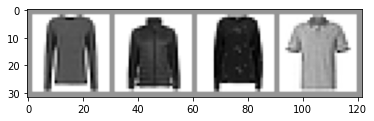

In [59]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [60]:
writer.add_graph(net, images)
writer.close()

In [61]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [62]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


## magics を使って，ノートブック内で TensorBoard を起動する．

In [63]:
import cgi, html
cgi.escape = html.escape

In [64]:
%tensorboard --logdir=log_dir

Reusing TensorBoard on port 6006 (pid 7344), started 3:11:43 ago. (Use '!kill 7344' to kill it.)

In [65]:
# summary writer を必要としない場合，close()メソッドを呼び出す
writer.close()

In [66]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir log_dir (started 5:14:00 ago; pid 15984)
  - port 6006: logdir log_file (started 3:06:58 ago; pid 27328)
  - port 6006: logdir log_dir/ (started 1:56:21 ago; pid 27344)
  - port 6006: logdir logs (started 5:02:08 ago; pid 6288)
  - port 6006: logdir log_dir (started 3:11:43 ago; pid 7344)


In [67]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir log_dir/ (started 1:56:21 ago; port 6006, pid 27344).
